In [1]:
import sys
sys.path.append("/mnt/d/work/searchformer")

In [7]:
from searchformer.sokoban import SokobanRenderer,sokoban_state_to_pretty_string,AStarSokobanState,Sokoban
import pygame
import json

In [3]:
with open("/mnt/d/work/searchformer/trace.json") as file:
    trace=json.load(file)

In [4]:
start_state=trace['sokoban_start']

In [5]:
actions=[]
for action in trace['trace']:
    if action['action']=='create' or action['action']=='close':
    # if action['action']=='plan':
        state=action['state']['state']
        actions.append(state)

In [6]:
len(actions)

388

In [3]:
renderer=SokobanRenderer(width=6,height=6,record_dir="D:\\work\\searchformer\\record_dir",assets_dir="D:\\work\\searchformer\\sokoban")
pygame.init()
clock = pygame.time.Clock()
running = True

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    for action in actions:
        renderer.render(game_state=action)
        pygame.display.flip()
        clock.tick(1)  # Optional: limit to 30 FPS
    # renderer.img_to_file()
    

pygame.quit()

NameError: name 'actions' is not defined

In [7]:
from PIL import Image
import os
from typing import List
from searchformer.sokoban import CellState
from PIL import Image, ImageDraw, ImageFont

class SokobanPILRenderer:
    def __init__(self, assets_dir: str, tile_size: int = 32):
        self.assets_dir = os.path.join(assets_dir, "images")
        self.tile_size = tile_size
        self.tiles = {
            CellState.wall: self.load("wall.png"),
            CellState.dock: self.load("dock.png"),
            CellState.floor: self.load("floor.png"),
            CellState.box: self.load("box.png"),
            CellState.box_on_dock: self.load("box_docked.png"),
            CellState.worker_on_floor: self.load("worker.png"),
            CellState.worker_on_dock: self.load("worker_dock.png"),
        }
        # You can also use a TTF font for better styling
        self.font = ImageFont.load_default()

    def load(self, filename):
        path = os.path.join(self.assets_dir, filename)
        assert os.path.exists(path), f"Image {path} not found."
        return Image.open(path).convert("RGBA").resize((self.tile_size, self.tile_size))

    def render_to_image(
        self,
        game_state: List[List[str]],
        action: str,
        cost_from_start: float,
        heuristic: float
    ) -> Image.Image:
        height = len(game_state)
        width = len(game_state[0])
        img = Image.new("RGBA", (width * self.tile_size, (height + 1) * self.tile_size), (255, 226, 191, 255))
        draw = ImageDraw.Draw(img)

        for y, row in enumerate(game_state):
            for x, cell in enumerate(row):
                tile = self.tiles.get(cell)
                if tile:
                    img.paste(tile, (x * self.tile_size, y * self.tile_size), mask=tile)

        # Write metadata below the board
        info_y = height * self.tile_size + 2
        draw.text((5, info_y), f"Action: {action}", font=self.font, fill=(0, 0, 0))
        draw.text((150, info_y), f"g: {cost_from_start}", font=self.font, fill=(0, 0, 0))
        draw.text((150, info_y+15), f"h: {heuristic}", font=self.font, fill=(0, 0, 0))

        return img


In [8]:
sokoban_pil_renderer=SokobanPILRenderer(assets_dir="/mnt/d/work/searchformer/sokoban")

In [8]:
start_state=[
        ["#", "#", "#", "#", "#", "#"
        ],
        ["#", " ", " ", " ", "@", "#"
        ],
        ["#", "#", "$", "$", " ", "#"
        ],
        ["#", ".", " ", ".", " ", "#"
        ],
        ["#", "#", " ", " ", " ", "#"
        ],
        ["#", "#", "#", "#", "#", "#"
        ]
    ]

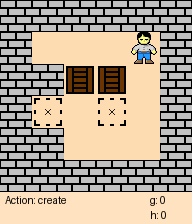

In [10]:
sokoban_pil_renderer.render_to_image(game_state=start_state,action='create',cost_from_start=0,heuristic=0)

In [13]:
import os
record_dir="/mnt/d/work/searchformer/trace_dir"

In [66]:
# start state
sokoban_pil_renderer.render_to_image(trace['sokoban_start'],action='start',cost_from_start=0,heuristic=0).save(os.path.join(record_dir,"start_state.png"))

In [14]:
for index, act in enumerate(trace['trace']):
    sokoban_pil_renderer.render_to_image(game_state=act['state']['state'],cost_from_start=act['cost_from_start'],heuristic=act['heuristic'],action=act['action']).save(os.path.join(record_dir,f"trace_{index}.png"))

In [4]:
class StateManager:
    def __init__(self) -> None:
        self.state_dict = {}
        self.counter = 0

    def state_to_node_id(self, state) -> int:
        id = self.state_dict.get(state, None)
        if id is not None:
            self.state_dict.pop(state)
            self.state_dict[state] = id
            return id
        id = self.counter
        self.state_dict[state] = self.counter
        self.counter = self.counter + 1
        return id

    def node_id_to_state(self, node_id: int) -> AStarSokobanState:
        for k, v in self.state_dict.items():
            if v == node_id:
                return k
        return None

    def check_node_id(self, node) -> dict:
        out = {}
        for node in [node]:
            id = self.state_dict.get(node, None)
            out[node] = id
        return out

    def update_node_id(self, node, node_id):
        self.state_dict[node] = node_id

In [11]:
import math
from typing import Dict,Tuple,List
from heapq import heappop,heappush

In [6]:
def check_heap(pq, n):
    for el in pq:
        if hash(n) == hash(el[1]):
            return el
    return None


def a_star_simple(start_state: AStarSokobanState):
    id: int = 0
    messages: List[Dict] = []
    last = {}
    cost = {}
    state_manager = StateManager()
    graph = {}
    heap = []
    pq: List[Tuple[float, AStarSokobanState]] = []
    rep_start = sokoban_state_to_pretty_string(start_state.state["state"])
    m0 = f"start state: {rep_start}\ncost: {start_state.cost}"
    messages.append({"role": "user", "content": m0})
    m1 = f"start state: {rep_start}\ncheck node id\nAction: check_node_id('{rep_start}')"
    messages.append({"role": "assistant", "content": m1})
    m2 = f"observation: {state_manager.check_node_id(rep_start)}"
    messages.append({"role": "user", "content": m2})
    m3: str = (
        f"Node does not exist yet assigning node id\nAction: update_node_id(node='{rep_start}',node_id={id})"
    )
    messages.append({"role": "assistant", "content": m3})
    state_manager.state_dict[rep_start] = id
    messages.append({"role": "user", "content": "observation: done"})
    graph[id] = []
    m4 = f"adding node to the graph \ngraph={graph}\npushing node to the heap with its heuristic\nAction: push_heap(cost={start_state.heuristic},node_id={id})"
    messages.append({"role": "assistant", "content": m4})
    heappush(pq, (start_state.heuristic, start_state))
    heappush(heap, (start_state.cost, id))
    m5 = "observation: done"
    messages.append({"role": "user", "content": m5})
    m6 = (
        f"updating cost of the state\nAction: update_cost(cost=0,node_id={id})"
    )
    messages.append({"role": "assistant", "content": m6})
    cost[rep_start] = 0
    m7 = "observation: done"
    messages.append({"role": "user", "content": m7})
    m8 = "initializing the search"
    messages.append({"role": "assistant", "content": m8})
    while len(pq) > 0:
        m9 = "selecting the lowest cost node from the heap"
        h, current = heappop(pq)
        rep_current = sokoban_state_to_pretty_string(
            current.state["state"]
        )
        current_id = state_manager.state_dict[rep_current]
        heap.remove((h, current_id))
        m10 = "Action: pop_heap()"
        messages.append({"role": "assistant", "content": f"{m9}\n{m10}"})
        m11 = "observation: " + str({"node_id": current_id, "heuristic": h})
        messages.append({"role": "user", "content": m11})
        
        m11_=f"checking cost of the current node\nAction: check_cost(node_id={current_id})"
        messages.append({"role":"assistant","content":m11_})
        m11__=f"observation: {cost[rep_current]}"
        messages.append({"role":"user","content":m11__})
        m12 = f"check if the current node is goal node\nAction: check_goal(node_id={current_id})"
        messages.append({"role": "assistant", "content": m12})
        if current.is_goal:
            m13 = "observation: True"
            messages.append({"role": "user", "content": m13})
            m14 = "goal is reached exiting the search"
            messages.append({"role": "assistant", "content": m14})
            return last, messages
        else:
            m15 = "observation: False"
            messages.append({"role": "user", "content": m15})
            m16 = f"current node is not goal node so exploring its childs\nAction: get_childs(node_id={current_id})"
            messages.append({"role": "assistant", "content": m16})
            childs_rep = []
            for child in current.children:
                childs_rep.append(
                    sokoban_state_to_pretty_string(child.state["state"])
                )
            m17 = f"observation: {childs_rep}"
            messages.append({"role": "user", "content": m17})

        for neighbor in current.children:

            rep_neighbor = sokoban_state_to_pretty_string(
                neighbor.state["state"]
            )
            m18 = f"current child is {rep_neighbor}"
            m19 = f"checking node id\nAction: check_node_id('{rep_neighbor}')"
            messages.append({"role": "assistant", "content": m18 + "\n" + m19})
            child_id = state_manager.check_node_id(rep_neighbor)[rep_neighbor]
            # print(child_id)
            m20 = f"observation: {child_id}"
            messages.append({"role": "user", "content": m20})

            if child_id is not None:
                m21 = "child node already has an id so continuing"
                messages.append({"role": "assistant", "content": m21})
            else:
                id += 1
                m22 = f"child node does not have and id so assigning one\nAction: update_node_id(node='{rep_neighbor}',node_id={id})"
                messages.append({"role": "assistant", "content": m22})
                m23 = "observation: done"
                messages.append({"role": "user", "content": m23})
                state_manager.state_dict[rep_neighbor] = id
                child_id = id
            
            m24 = f"checking cost of the current child\nAction: check_cost(node_id={id})"
            messages.append({"role": "assistant", "content": m24})
            old_cost = cost.get(rep_neighbor, None)
            if old_cost is None:
                old_cost = math.inf
                cost[rep_neighbor] = math.inf
            m25 = f"observation: {old_cost}"
            messages.append({"role": "user", "content": m25})
            new_cost = cost[rep_current] + 1

            if cost[rep_neighbor] > cost[rep_current] + 1:
                m26 = f"new cost is the cost of the parent +1 which is new_cost={cost[rep_current]}+1={new_cost}\nsince new cost is less than the old cost\n{old_cost}>{new_cost}\nupdating the cost of the neighbour\nAction: update_cost(node_id={child_id},cost={new_cost})"
                messages.append({"role": "assistant", "content": m26})
                cost[rep_neighbor] = cost[rep_current] + 1
                m27 = "observation: done"
                messages.append({"role": "user", "content": m27})
                m28 = f"updating the parent of the child node\nAction: update_parent(child={child_id},parent={current_id})"
                messages.append({"role": "assistant", "content": m28})
                last[rep_neighbor] = rep_current
                m29 = "observation: done"
                messages.append({"role": "user", "content": m29})
                m30 = f"getting heuristic of the current child\nAction: get_heuristic(node_id={child_id})"
                messages.append({"role": "assistant", "content": m30})
                m31 = f"observation: {neighbor.heuristic}"
                messages.append({"role": "user", "content": m31})
                est_value: float = cost[rep_neighbor] + neighbor.heuristic
                m32 = f"calculating the estimated cost of the current child which is new cost plus the heuristic cost of the current child so estimated_cost={new_cost}+{neighbor.heuristic}={est_value}\nchecking whether the current child is already in heap\nAction: check_heap(node_id={child_id})"
                messages.append({"role": "assistant", "content": m32})
                is_neighbor_in_pq = check_heap(pq, neighbor)
                is_neighbor_in_heap = check_heap(heap, child_id)
                if is_neighbor_in_pq:
                    m33 = f"observation: {is_neighbor_in_heap}"
                    messages.append({"role": "user", "content": m33})
                    m34 = f"since the current child: {child_id} is in the heap with cost: {is_neighbor_in_heap[0]}. Removing it from the heap\nAction: remove_heap(cost={is_neighbor_in_heap[0]},node_id={child_id})"
                    messages.append({"role": "assistant", "content": m34})
                    pq.remove(is_neighbor_in_pq)
                    heap.remove(is_neighbor_in_heap)
                    m35 = "observation: done"
                    messages.append({"role": "user", "content": m35})
                    m36 = f"pushing the child node with new estimated cost in the heap\nAction: push_heap(cost={est_value},node_id={child_id})"
                    messages.append({"role": "assistant", "content": m36})
                    heappush(heap, (est_value, child_id))
                    heappush(pq, (est_value, neighbor))
                    m37 = "observation: done"
                    messages.append({"role": "user", "content": m37})
                else:
                    m38 = "observation: None"
                    messages.append({"role": "user", "content": m38})
                    m39 = f"since current child is not in the heap. So pushing it to the heap with the estimated cost\nAction: push_heap(cost={est_value},node_id={child_id})"
                    messages.append({"role": "assistant", "content": m39})
                    heappush(pq, (est_value, neighbor))
                    heappush(heap, (est_value, child_id))
                    m40 = "observation: done"
                    messages.append({"role": "user", "content": m40})
            else:
                m41 = f"new cost is the cost of the parent +1 which is new_cost={new_cost}\nsince new cost is greater than the old cost\n{old_cost}<{new_cost}\nso continuing"
                messages.append({"role": "assistant", "content": m41})
            if not graph.get(child_id):
                graph[child_id] = []

            if child_id not in graph[current_id]:
                graph[current_id].append(child_id)

            if current_id not in graph[child_id]:
                graph[child_id].append(current_id)
            messages.append(
                {"role": "assistant", "content": f"current graph is :{graph}"}
            )

    return last, messages

In [9]:
start_state=[
        ["#", "#", "#", "#", "#", "#"
        ],
        ["#", " ", " ", " ", "@", "#"
        ],
        ["#", "#", "$", "$", " ", "#"
        ],
        ["#", ".", " ", ".", " ", "#"
        ],
        ["#", "#", " ", " ", " ", "#"
        ],
        ["#", "#", "#", "#", "#", "#"
        ]
    ]

In [12]:
path, messages_ = a_star_simple(
    AStarSokobanState(Sokoban(start_state))
)

In [13]:
messages_

[{'role': 'user',
  'content': 'start state: ######\n#   @#\n##$$ #\n#. . #\n##   #\n######\ncost: 3.0'},
 {'role': 'assistant',
  'content': "start state: ######\n#   @#\n##$$ #\n#. . #\n##   #\n######\ncheck node id\nAction: check_node_id('######\n#   @#\n##$$ #\n#. . #\n##   #\n######')"},
 {'role': 'user',
  'content': "observation: {'######\\n#   @#\\n##$$ #\\n#. . #\\n##   #\\n######': None}"},
 {'role': 'assistant',
  'content': "Node does not exist yet assigning node id\nAction: update_node_id(node='######\n#   @#\n##$$ #\n#. . #\n##   #\n######',node_id=0)"},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant',
  'content': 'adding node to the graph \ngraph={0: []}\npushing node to the heap with its heuristic\nAction: push_heap(cost=3.0,node_id=0)'},
 {'role': 'user', 'content': 'observation: done'},
 {'role': 'assistant',
  'content': 'updating cost of the state\nAction: update_cost(cost=0,node_id=0)'},
 {'role': 'user', 'content': 'observation: done'},
 

In [14]:
for message in messages_:
    print(message["content"])

start state: ######
#   @#
##$$ #
#. . #
##   #
######
cost: 3.0
start state: ######
#   @#
##$$ #
#. . #
##   #
######
check node id
Action: check_node_id('######
#   @#
##$$ #
#. . #
##   #
######')
observation: {'######\n#   @#\n##$$ #\n#. . #\n##   #\n######': None}
Node does not exist yet assigning node id
Action: update_node_id(node='######
#   @#
##$$ #
#. . #
##   #
######',node_id=0)
observation: done
adding node to the graph 
graph={0: []}
pushing node to the heap with its heuristic
Action: push_heap(cost=3.0,node_id=0)
observation: done
updating cost of the state
Action: update_cost(cost=0,node_id=0)
observation: done
initializing the search
selecting the lowest cost node from the heap
Action: pop_heap()
observation: {'node_id': 0, 'heuristic': 3.0}
checking cost of the current node
Action: check_cost(node_id=0)
observation: 0
check if the current node is goal node
Action: check_goal(node_id=0)
observation: False
current node is not goal node so exploring its childs
Action: 